**Load data**

In [18]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn


# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7
USE_MIXED = False
USE_PRESSURE_TEMP = True
USE_FIFTY_FIFTY = True
USE_SPECIFIC_CLOUDS = True
cloud_types = [0, 3, 4] #0,1,2 ::: 0, 3, 4
low_vis_threshold = 50000
noise_level = 0.01 # % of max
dnn_batch_size = 32


if USE_MIXED:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_mixed.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_mixed.dat', 'fog_data_ir_water.dat']
else:
    filenames_vis = ['fog_data_vis_clear.dat', 'fog_data_vis_ice.dat', 'fog_data_vis_water.dat']
    filenames_ir = ['fog_data_ir_clear.dat', 'fog_data_ir_ice.dat', 'fog_data_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate((np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])


# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

# 19 Data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if USE_FIFTY_FIFTY:
    fifty_fifty = data_ir_vis[np.where(data_ir_vis[:,30] < low_vis_threshold)[0]]
    high_vis_i = np.where(data_ir_vis[:,30] >= low_vis_threshold)[0]
    if len(fifty_fifty) > len(high_vis_i):
       print('Not enough high vis data for 50/50')
    r_high_vis_i = np.random.choice(high_vis_i, len(fifty_fifty), replace=False)
    fifty_fifty = np.vstack([fifty_fifty, data_ir_vis[r_high_vis_i]])
    data_ir_vis = fifty_fifty
    
# if USE_SPECIFIC_CLOUDS:                                                 # FIXA SÅ DETTA HÄNDER EFTER CLOUD TYPE, TROR INTE BÅDA FUNKAR ANNARS
#     masked_data = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]
#     X = masked_data[:, features_i]
#     y = masked_data[:,target_i]
# else:
#     X = data_ir_vis[:, features_i]
#     y = data_ir_vis[:,target_i]

X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

data_noisy = np.zeros_like(data_ir_vis)
noise_std_devs = np.zeros(data_ir_vis.shape[1])

for feature_i in range(data_ir_vis.shape[1]):
    noise_std = np.max(data_ir_vis[:,feature_i]) * noise_level # 1% of mean or max??
    noise_std_devs[feature_i] = noise_std
    data_noisy[:,feature_i] = data_ir_vis[:,feature_i] + np.random.normal(0, noise_std, data_ir_vis[:,feature_i].shape)

features_std_devs = noise_std_devs[features_i]



# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(features_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y_scaled, test_size=(1/20), random_state=16)

# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(1/19), random_state=16)


# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_label = np.zeros_like(y_train, dtype=int)
y_val_label = np.zeros_like(y_val, dtype=int)
y_test_label = np.zeros_like(y_test, dtype=int)


for i in np.where(target_scaler.inverse_transform(y_train) < low_vis_threshold)[0]:
   y_train_label[i] = 1

for i in np.where(target_scaler.inverse_transform(y_val) < low_vis_threshold)[0]:
   y_val_label[i] = 1

for i in np.where(target_scaler.inverse_transform(y_test) < low_vis_threshold)[0]:
   y_test_label[i] = 1

# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size=dnn_batch_size)
training_data_classes = tf.data.Dataset.from_tensor_slices((X_train, y_train_label)).batch(batch_size=64)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_classes = training_data_classes.map(noise_map)

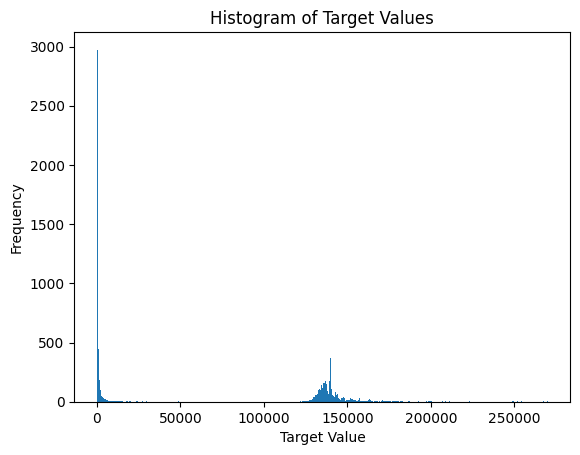

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your target values are in a NumPy array called 'target_values'
plt.hist(y, bins=500)
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.title("Histogram of Target Values")
plt.show()

Add noise (not done)

In [ ]:
bands_snr = [128, 201, 243, 228, 74, 275, 110, 880, 838, 802, 754, 750, 910, 1087, 586, 516, 167, 57, 250,
        None, None, None, None, None, None, 150, None, None, None, None, None, None, None, None, None, None]

bands_netd = [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None,
         None, None, 0.05, 0.2, 0.07, 0.07, 0.25, 0.25, None, 0.25, 0.25, 0.05, 0.25, 0.05, 0.05, 0.25, 0.25, 0.25, 0.35]


snr_netd = zip(bands_snr, bands_netd)
all_bands = data_ir_vis[:,1:30]
print(all_bands[0,:])

print(all_bands.shape)

for band_i, (snr, netd) in enumerate(snr_netd):
    if snr != None:
        avg_squared_signal_pwr = np.mean(np.square(all_bands[:, band_i]))
        noise_std = np.sqrt(avg_squared_signal_pwr / snr)
    else:
        noise_std = netd

    all_bands[:, band_i] += np.random.normal(0, noise_std, all_bands[:, band_i].shape)

In [ ]:
data_ir_vis = []

for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

Random Forest Regressor

Mean Squared Error: 0.6128729113369529


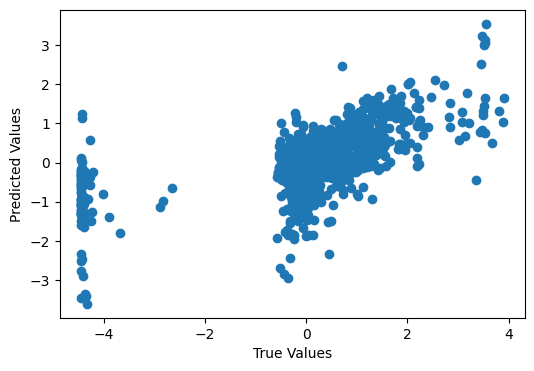

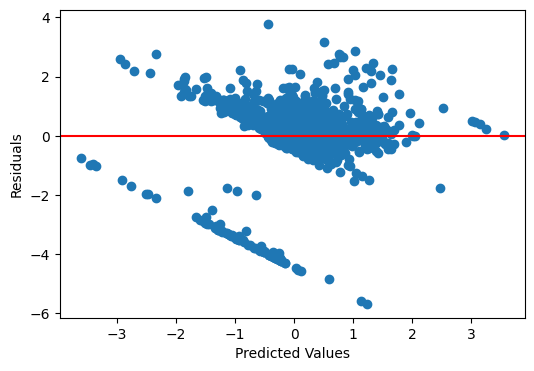

In [27]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_noisy, y_train.ravel())

y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred 

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()


Gradient Boosting Regressor

Mean Squared Error: 0.6247968936755467


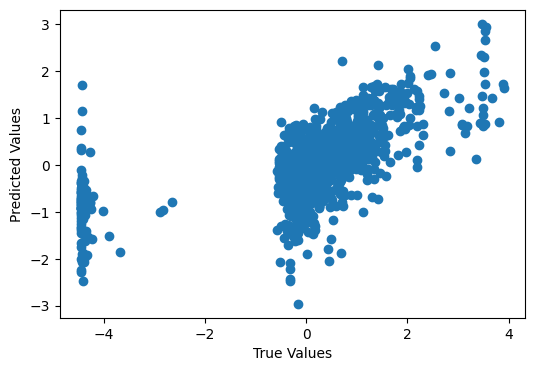

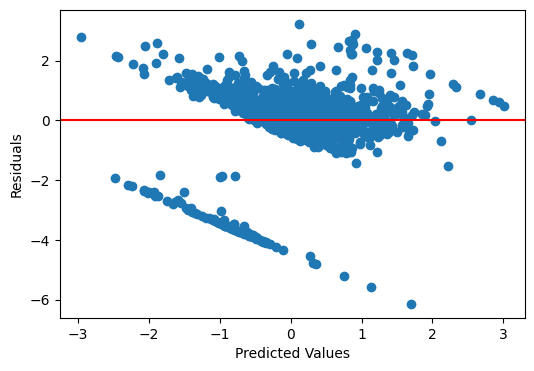

In [28]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train.ravel())

y_pred = gb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test.ravel() - y_pred

print("Mean Squared Error:", mse)

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

DNN Regression

In [ ]:
from keras import layers
from keras import regularizers

# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data, epochs = 150, validation_data=(X_val_noisy, y_val))


y_pred = ff_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
residuals = y_test - y_pred 

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

In [33]:
print(mse)

0.46207178


DNN Classification

In [29]:
import keras.backend as K

def custom_loss(y_true, y_pred):
    # Define the binary cross-entropy loss
    bce_loss = K.binary_crossentropy(y_true, y_pred)
    
    # Define a penalty for false negatives
    # Adjust the value of alpha based on the importance of reducing false negatives
    alpha = 0.5  # Example value, you can adjust as needed
    false_negative_penalty = alpha * K.sum(y_true * K.cast(K.greater(y_pred, 0.5), 'float32'), axis=-1)
    
    # Add the penalty to the loss
    total_loss = bce_loss + false_negative_penalty
    
    return total_loss

In [22]:
from keras import layers
from keras import regularizers
from sklearn.metrics import classification_report


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
 
    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data_classes, epochs = 150, validation_data=(X_val_noisy, y_val_label))


y_pred = ff_model.predict(X_test)

y_pred_label = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_label, y_pred_label)

Epoch 1/150


/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6231 - loss: 0.8903 - val_accuracy: 0.8087 - val_loss: 0.6130
Epoch 2/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7905 - loss: 0.6225 - val_accuracy: 0.8184 - val_loss: 0.5483
Epoch 3/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8034 - loss: 0.5563 - val_accuracy: 0.8232 - val_loss: 0.5026
Epoch 4/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.5154 - val_accuracy: 0.8354 - val_loss: 0.4755
Epoch 5/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8035 - loss: 0.4936 - val_accuracy: 0.8402 - val_loss: 0.4431
Epoch 6/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8126 - loss: 0.4596 - val_accuracy: 0.8426 - val_loss: 0.4186
Epoch 7/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8231 - loss: 0.4390 - val_accuracy: 0.8547 - val_loss: 0.4068
Epoch 8/150
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8308 - loss: 0.4266 - val_accuracy: 0.85

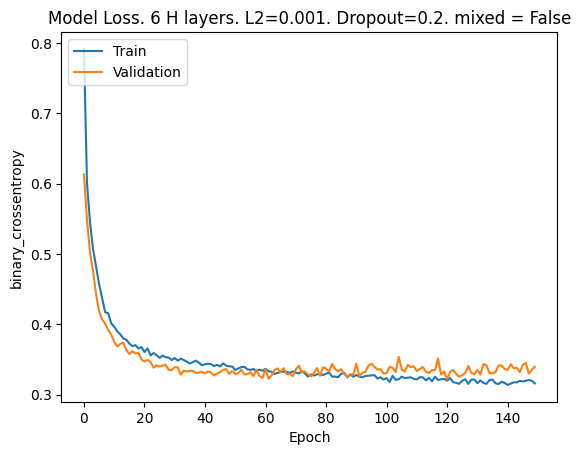

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       198
           1       0.82      0.98      0.89       215

    accuracy                           0.88       413
   macro avg       0.89      0.87      0.87       413
weighted avg       0.89      0.88      0.87       413



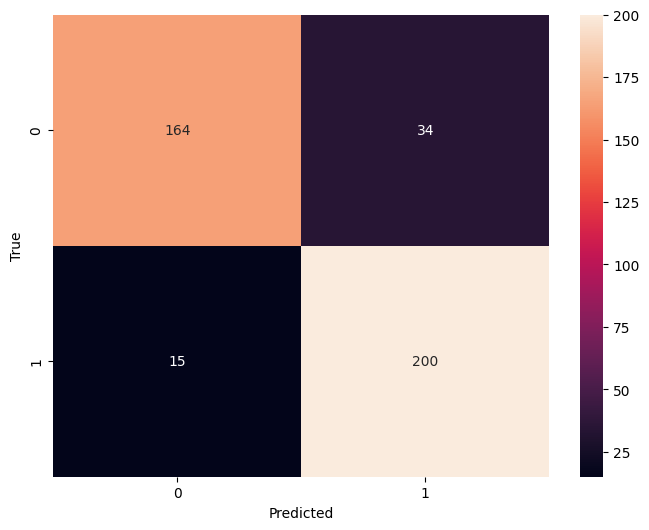

threshold: 0.2
0.8765133171912833
threshold: 0.3
0.8813559322033898
threshold: 0.4
0.8861985472154964
threshold: 0.5
0.8813559322033898
threshold: 0.6
0.8813559322033898
threshold: 0.7
0.8353510895883777
threshold: 0.8
0.7530266343825666


In [27]:
from sklearn.metrics import classification_report

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_label, y_pred_label))

plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import accuracy_score

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for t in thresholds:
    y_pred_label = (y_pred > t ).astype(int)
    print(f'threshold: {t}')
    print(accuracy_score(y_test_label, y_pred_label))

TypeError: missing a required argument: 'y_pred'

QRNN (not working)

In [ ]:
import keras
import quantnn as q

quantiles=[0.1, 0.5, 0.9]
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, n_inputs=1, model=model)
training_data = (X_train, y_train)
# Model setup
model = qrnn(quantiles=[0.1, 0.5, 0.9], n_inputs=len(features_i))  # Estimate 10th, 50th, 90th percentiles
results = qrnn.train(training_data=training_data, n_epochs=15)

# Model fitting
model.train(X_train, y_train, epochs=100)

# Predictions
predictions = model.predict(X_test) 
print(predictions)

In [ ]:
from typhon.retrieval.qrnn.qrnn import QRNN

# 2. Create QRNN Model (Same as before)
model = QRNN(
    quantiles=[0.1, 0.5, 0.9],  
    input_dimensions=X_train.shape[1],
    model=(3, 128, 'relu'),
    initial_learning_rate = 0.01
)

training_data = (X_train, y_train)
validation_data = (X_val, y_val)

# 3. Train the Model (Updated)
model.train(training_data, validation_data, batch_size=32) 